In this analysis were going to predict the death rate and the recovery rate of COVID19 and compute the probabilities. Therefore were going to import the necessary packages and load the data

In [1]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

import pandas
import xgboost
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import pickle
from sklearn.externals import joblib

from numpy import argmax
from keras.utils import to_categorical

C:\Users\Alexandra\Anaconda3\envs\tensorflow2\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Alexandra\Anaconda3\envs\tensorflow2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
covid19_df = pd.read_csv("dataset/COVID19_line_list_data.csv")

In [3]:
#here were looking at the death variable to unserstand how we have to clean the variable 
covid19_df['death'].value_counts()

0            1022
1              42
2/23/2020       4
2/26/2020       3
2/25/2020       2
2/27/2020       2
2/21/2020       2
2/19/2020       2
2/22/2020       1
02/01/20        1
2/28/2020       1
2/24/2020       1
2/13/2020       1
2/14/2020       1
Name: death, dtype: int64

deleting the columns we dont need for our analysis

In [5]:
del covid19_df["case_in_country"]
del covid19_df['Unnamed: 3']
del covid19_df["location"]
del covid19_df["If_onset_approximated"]
del covid19_df['hosp_visit_date']
del covid19_df["source"]
del covid19_df["link"]
del covid19_df['Unnamed: 21']
del covid19_df['Unnamed: 22']
del covid19_df['Unnamed: 23']
del covid19_df['Unnamed: 24']
del covid19_df['Unnamed: 25']
del covid19_df['Unnamed: 26']
del covid19_df["summary"]
del covid19_df["exposure_end"]
del covid19_df["exposure_start"]
del covid19_df["id"]
del covid19_df['reporting date']

KeyError: 'case_in_country'

lets have a look at the symptoms und get them ready for our model

In [6]:
#codierung symptoms
covid19_df["symptom"].unique()

d = {1: True, 0: False}
res = covid19_df.join(covid19_df.pop('symptom').str.get_dummies(',').applymap(d.get))
#print(res)



In [7]:
res.columns

Index(['country', 'gender', 'age', 'symptom_onset', 'visiting Wuhan',
       'from Wuhan', 'death', 'recovered', ' abdominal pain',
       ' aching muscles', ' breathlessness', ' chest pain', ' chill',
       ' chills', ' cold', ' cough', ' coughing', ' diarrhea',
       ' difficult in breathing', ' difficulty breathing', ' dyspnea',
       ' fatigue', ' fever', ' flu', ' headache', ' heavy head',
       ' itchy throat', ' joint pain', ' loss of appetite', ' malaise',
       ' muscle aches', ' muscle cramps', ' muscle pain', ' myalgia',
       ' myalgias', ' nasal discharge', ' nausea', ' pneumonia',
       ' respiratory distress', ' runny nose', ' shortness of breath',
       ' sneeze', ' sore throat', ' sputum', ' thirst', ' throat discomfort',
       ' vomiting', 'chest discomfort', 'chills', 'cold', 'cough',
       'cough with sputum', 'difficulty breathing', 'fatigue', 'feaver',
       'feve\', 'fever', 'flu symptoms', 'headache', 'high fever',
       'joint pain', 'malaise', 'mil

In [8]:

# Merge same sympthoms

res['malaise'][res[' malaise']==True]=True
res['nausea'][res[' nausea']==True]=True

res[' cough'][res[' coughing'] == True] = True
res[' cough'][res['cough'] == True] = True
res[' cough'][res['mild cough'] == True] = True
res[' cough'][res['cough with sputum'] == True] = True

res[' chill'][res[' chills'] == True] = True
res[' chill'][res[' cold'] == True] = True
res[' chill'][res['chills'] == True] = True
res[' chill'][res['cold'] == True] = True

res[' cough'][res[' coughing'] == True] = True

res[' muscle pain'][res[' myalgia'] == True] = True
res[' muscle pain'][res[' myalgias'] == True] = True
res[' muscle pain'][res[' muscle aches'] == True] = True
res[' muscle pain'][res[' muscle cramps'] == True] = True
res[' muscle pain'][res['myalgia']==True]=True
res[' muscle pain'][res[' aching muscles']==True]=True

res['fever'][res[' fever']==True]=True
res['fever'][res['feaver']==True]=True
res['fever'][res['feve\\']==True]=True
res['fever'][res['fever']==True]=True
res['fever'][res['high fever']==True]=True
res['fever'][res['mild fever']==True]=True

res['tired'][res[' fatigue']==True]=True
res['tired'][res['fatigue']==True]=True


res[' difficult in breathing'][res[' breathlessness']==True]=True
res[' difficult in breathing'][res[' difficulty breathing']==True]=True
res[' difficult in breathing'][res[' respiratory distress']==True]=True
res[' difficult in breathing'][res[' shortness of breath']==True]=True
res[' difficult in breathing'][res['difficulty breathing']==True]=True
res[' difficult in breathing'][res['chest discomfort']==True]=True

res['vomiting'][res['reflux']==True]=True
res['vomiting'][res[' vomiting']==True]=True

res['throat pain'][res['throat discomfort']==True]=True
res['throat pain'][res['sore throat']==True]=True
res['throat pain'][res[' throat discomfort']==True]=True
res['throat pain'][res[' sore throat']==True]=True
res['throat pain'][res[' itchy throat']==True]=True


res['flu symptoms'][res[' flu']==True]=True


res['runny nose'][res[' sneeze']==True]=True
res['runny nose'][res['sore throat']==True]=True
res['runny nose'][res[' runny nose']==True]=True
res['runny nose'][res[' nasal discharge']==True]=True


res['headache'][res[' headache']==True]=True
res['headache'][res[' heavy head']==True]=True





C:\Users\Alexandra\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Alexandra\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Alexandra\Anaconda3\envs\tensorflow2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyda

In [9]:
#here were deleting the empty columns after the merge 

del res[' coughing']
del res['cough']
del res['mild cough']
del res['cough with sputum']

del res['chills']
del res['cold']
del res[' chills']
del res[' cold']

del res[' myalgia']
del res[' myalgias']
del res[' muscle aches']
del res[' muscle cramps']
del res['myalgia']
del res[' aching muscles']

del res[' headache']
del res[' heavy head']
del res[' sneeze']
del res[' sore throat']
del res[' runny nose']
del res[' flu']
del res['throat discomfort']
del res['sore throat']
del res[' throat discomfort']
del res[' itchy throat']
del res['reflux']
del res[' vomiting']
del res[' breathlessness']
del res[' difficulty breathing']
del res[' respiratory distress']
del res[' shortness of breath']
del res['difficulty breathing']
del res['chest discomfort']
del res[' fever']
del res['feaver']
del res['feve\\']
del res['high fever']
del res['mild fever']
del res[' fatigue']
del res['fatigue']

del res[' malaise']
del res[' nausea']
del res[' nasal discharge']

lets check if everything went well

In [10]:
res[' cough'].value_counts()

False    968
True     117
Name:  cough, dtype: int64

In [11]:
res[' chill'].value_counts()

False    1069
True       16
Name:  chill, dtype: int64

lets get our data and the symptoms together


In [12]:
covid19_df=res

In [13]:
covid19_df.head()

,country,gender,age,symptom_onset,visiting Wuhan,from Wuhan,death,recovered,abdominal pain,chest pain,...,headache,joint pain,malaise,nausea,physical discomfort,runny nose,sore body,throat pain,tired,vomiting
0,China,male,66.0,01/03/20,1,0.0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,China,female,56.0,1/15/2020,0,1.0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,China,male,46.0,01/04/20,0,1.0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,China,female,60.0,NaN,1,0.0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False
4,China,male,58.0,NaN,0,0.0,0,0,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
covid19_df.shape

(1085, 33)

In [15]:
#Data Cleaning 
def gender(str):
    if str == "male":
        return 0
    else:
        return 1
    
covid19_df["gender"] = covid19_df["gender"].apply(gender)

we will greate dummies to get our countries in shape for the analysis 

In [16]:
dummies_country = pd.get_dummies(covid19_df['country'])
dummies_country['Spain'].value_counts()

0    1051
1      34
Name: Spain, dtype: int64

In [17]:
covid19_df = pd.concat([covid19_df,dummies_country],axis=1)

In [18]:
covid19_df.head()

,country,gender,age,symptom_onset,visiting Wuhan,from Wuhan,death,recovered,abdominal pain,chest pain,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,UAE,UK,USA,Vietnam
0,China,0,66.0,01/03/20,1,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
1,China,1,56.0,1/15/2020,0,1.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
2,China,0,46.0,01/04/20,0,1.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
3,China,1,60.0,NaN,1,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
4,China,0,58.0,NaN,0,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0


In [19]:
del covid19_df['country']

In [21]:
#lets have a look at the data: data analysis

Text(0, 0.5, 'Age')

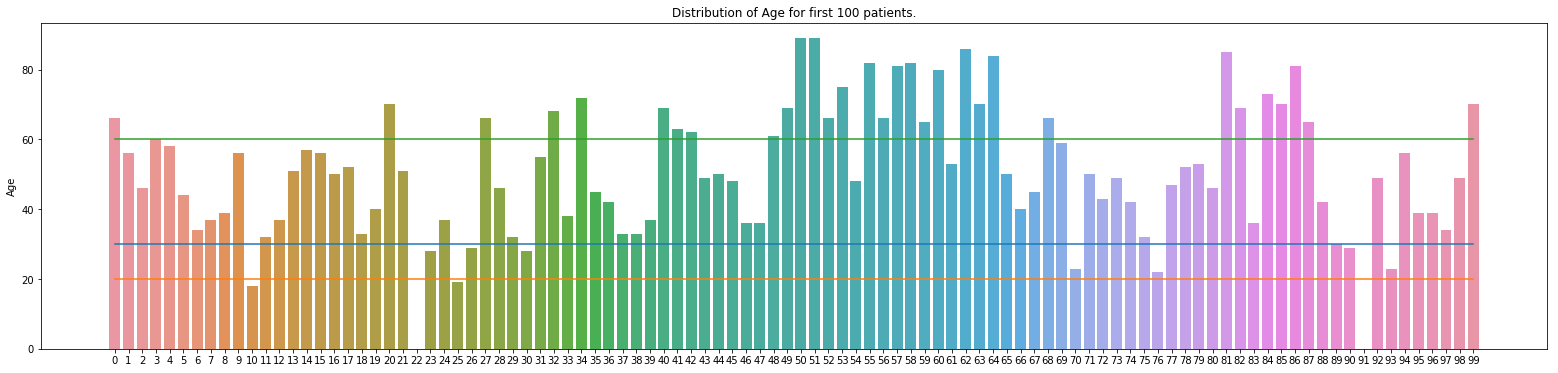

In [19]:
#Age
a = [30 for i in range(100)]
b = [20 for i in range(100)]
c = [60 for i in range(100)]
plt.figure(figsize=(27,6))

plt.title("Distribution of Age for first 100 patients.")
sns.barplot(x=covid19_df.index[:100], y=covid19_df['age'][:100])

plt.plot(a)
plt.plot(b)
plt.plot(c)
plt.ylabel("Age")

Text(0, 0.5, 'Age')

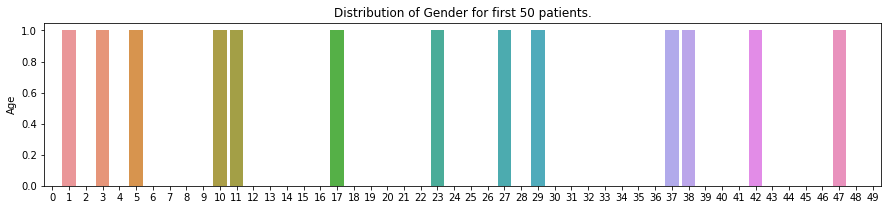

In [20]:
#Gender 
plt.figure(figsize=(15,3))

plt.title("Distribution of Gender for first 50 patients.")
sns.barplot(x=covid19_df.index[:50], y=covid19_df['gender'][:50])

plt.ylabel("Age")

In [30]:
#final data preparation: 

In [20]:
covid19_df.reset_index(inplace = True) 
covid19_df.head()

,index,gender,age,symptom_onset,visiting Wuhan,from Wuhan,death,recovered,abdominal pain,chest pain,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,UAE,UK,USA,Vietnam
0,0,0,66.0,01/03/20,1,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
1,1,1,56.0,1/15/2020,0,1.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
2,2,0,46.0,01/04/20,0,1.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
3,3,1,60.0,NaN,1,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
4,4,0,58.0,NaN,0,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0


In [21]:
covid19_df['age'].value_counts()

55.0    72
65.0    52
45.0    39
75.0    37
35.0    36
        ..
1.0      1
0.5      1
87.0     1
84.0     1
91.0     1
Name: age, Length: 85, dtype: int64

In [22]:
covid19_df["age"].fillna(45, inplace = True)
covid19_df["from Wuhan"].fillna(1, inplace = True)
covid19_df["visiting Wuhan"].fillna(1, inplace = True)
covid19_df["death"].fillna(1, inplace = True)
covid19_df["recovered"].fillna(1, inplace = True)

In [23]:
covid19_df.head()

,index,gender,age,symptom_onset,visiting Wuhan,from Wuhan,death,recovered,abdominal pain,chest pain,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,UAE,UK,USA,Vietnam
0,0,0,66.0,01/03/20,1,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
1,1,1,56.0,1/15/2020,0,1.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
2,2,0,46.0,01/04/20,0,1.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
3,3,1,60.0,NaN,1,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0
4,4,0,58.0,NaN,0,0.0,0,0,False,False,...,0,0,0,0,0,0,0,0,0,0


In [24]:
def change(str):
    if str == '0':
        return 0
    elif str == '1':
        return 1
    elif str is not '0' or str is not '1':
        return 1
    else:
        return 

In [25]:
covid19_df["death"] = covid19_df["death"].apply(change)

In [26]:
covid19_df["recovered"] = covid19_df["recovered"].apply(change)

In [27]:
covid19_df.columns

Index(['index', 'gender', 'age', 'symptom_onset', 'visiting Wuhan',
       'from Wuhan', 'death', 'recovered', ' abdominal pain', ' chest pain',
       ' chill', ' cough', ' diarrhea', ' difficult in breathing', ' dyspnea',
       ' joint pain', ' loss of appetite', ' muscle pain', ' pneumonia',
       ' sputum', ' thirst', 'fever', 'flu symptoms', 'headache', 'joint pain',
       'malaise', 'nausea', 'physical discomfort', 'runny nose', 'sore body',
       'throat pain', 'tired', 'vomiting', 'Afghanistan', 'Algeria',
       'Australia', 'Austria', 'Bahrain', 'Belgium', 'Cambodia', 'Canada',
       'China', 'Croatia', 'Egypt', 'Finland', 'France', 'Germany',
       'Hong Kong', 'India', 'Iran', 'Israel', 'Italy', 'Japan', 'Kuwait',
       'Lebanon', 'Malaysia', 'Nepal', 'Phillipines', 'Russia', 'Singapore',
       'South Korea', 'Spain', 'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan',
       'Thailand', 'UAE', 'UK', 'USA', 'Vietnam'],
      dtype='object')

In [28]:
covid19_df['death'].value_counts()

0    1022
1      63
Name: death, dtype: int64

In [29]:
covid19_df.loc[:, ' abdominal pain':'vomiting'] = covid19_df.loc[:,' abdominal pain':'vomiting'].applymap(lambda x: 1 if x==True else 0)

In [30]:
del covid19_df['symptom_onset']
covid19_df.head()

,index,gender,age,visiting Wuhan,from Wuhan,death,recovered,abdominal pain,chest pain,chill,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,UAE,UK,USA,Vietnam
0,0,0,66.0,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,56.0,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,46.0,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,60.0,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,58.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:


Y1 = covid19_df["death"]
Y2 = covid19_df["recovered"]
covid19_df["death"]
covid19_df["recovered"]



0       0
1       0
2       0
3       0
4       0
       ..
1080    0
1081    0
1082    0
1083    0
1084    0
Name: recovered, Length: 1085, dtype: int64



Y1 = np.array(Y1)
Y2 = np.array(Y2)

for i in range(len(Y1)):
    if type(Y1[i] == str):
        Y1[i] = 1
        
for i in range(len(Y2)):
    if type(Y2[i] == str):
        Y2[i] = 1



X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X, Y1)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y2)

scaler = MinMaxScaler(feature_range=(0,1))
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

Now lets Build the XGBoost Model: 


In [32]:
covid19_df.head()

,index,gender,age,visiting Wuhan,from Wuhan,death,recovered,abdominal pain,chest pain,chill,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,UAE,UK,USA,Vietnam
0,0,0,66.0,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,56.0,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,46.0,0,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,60.0,1,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,58.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
X= covid19_df.drop(['death', 'recovered','index'], axis=1)
X.head()

,gender,age,visiting Wuhan,from Wuhan,abdominal pain,chest pain,chill,cough,diarrhea,difficult in breathing,...,Spain,Sri Lanka,Sweden,Switzerland,Taiwan,Thailand,UAE,UK,USA,Vietnam
0,0,66.0,1,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,56.0,0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,46.0,0,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,60.0,1,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,58.0,0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# deaths
Y = covid19_df.loc[:,'death']
Y.head()

Y.value_counts()
Y = Y.apply(pd.to_numeric, errors='coerce')
Y = Y.fillna(1)
Y = Y.reset_index(drop=True)


Y.value_counts()


0    1022
1      63
Name: death, dtype: int64

In [81]:
#model with accuracy
# encode string class values as integers
#label_encoder = LabelEncoder()
#label_encoder = label_encoder.fit(Y)
#label_encoded_y = label_encoder.transform(Y)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model = xgboost.XGBClassifier(objective='binary:logistic',learning_rate = 0.1, max_depth = 5, n_estimators = 10)
model.fit(X_train, y_train)
print(model)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy: 94.71%


In [83]:
#model with probability: 
# encode string class values as integers
#label_encoder = LabelEncoder()
#label_encoder = label_encoder.fit(Y)
#label_encoded_y = label_encoder.transform(Y)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
# fit model no training data
model1 = xgboost.XGBClassifier(objective='binary:logistic',learning_rate = 0.1, max_depth = 5, n_estimators = 10)
model1.fit(X_train, y_train)
print(model)
# make predictions for test data
y_pred1 = model1.predict_proba(X_test)
predictions1 = [value for value in y_pred1]
# evaluate predictions
accuracy1 = accuracy_score(y_test, predictions1)
print("Accuracy: %.2f%%" % (accuracy1 * 100.0))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

In [41]:
y_test.value_counts()

0    336
1     23
Name: death, dtype: int64

In [42]:
y_train.value_counts()

0    686
1     40
Name: death, dtype: int64

In [43]:
from collections import Counter

Counter(predictions).keys()

dict_keys([0, 1])

In [44]:
Counter(predictions).values()

dict_values([340, 19])

In [45]:
predictions

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [46]:
predictions1

[array([9.9959338e-01, 4.0664637e-04], dtype=float32),
 array([0.8711277 , 0.12887226], dtype=float32),
 array([0.7879743 , 0.21202569], dtype=float32),
 array([0.97218233, 0.02781764], dtype=float32),
 array([9.9968702e-01, 3.1299485e-04], dtype=float32),
 array([9.9976867e-01, 2.3134494e-04], dtype=float32),
 array([9.9982071e-01, 1.7927088e-04], dtype=float32),
 array([9.9905425e-01, 9.4574830e-04], dtype=float32),
 array([9.9982071e-01, 1.7927088e-04], dtype=float32),
 array([0.96901304, 0.03098695], dtype=float32),
 array([0.99455816, 0.00544185], dtype=float32),
 array([0.0283516, 0.9716484], dtype=float32),
 array([0.03885317, 0.96114683], dtype=float32),
 array([9.993374e-01, 6.626374e-04], dtype=float32),
 array([0.9984266, 0.0015734], dtype=float32),
 array([0.997428  , 0.00257203], dtype=float32),
 array([0.99475825, 0.00524177], dtype=float32),
 array([0.998384  , 0.00161601], dtype=float32),
 array([9.9982071e-01, 1.7927088e-04], dtype=float32),
 array([0.6077327, 0.392267

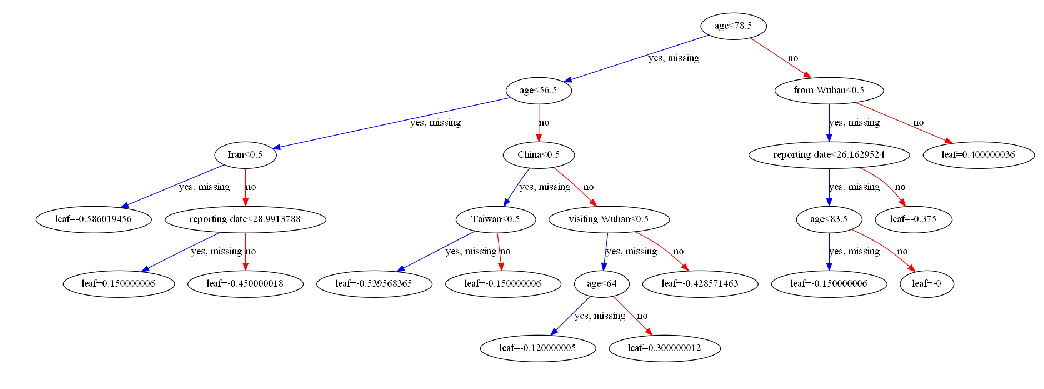

In [54]:
#Plotting out XGBoost Model: 
import matplotlib.pyplot as plt

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'
import graphviz

xgb.plot_tree(model,num_trees=0)
plt.rcParams['figure.figsize'] = [500, 100]
plt.savefig('model.png')
plt.show()

In [ ]:
#plotting the variable importance
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [16, 16]
plt.show()

In [48]:
#prediction of recovery: 
#define our Y to predict the recovery: 
# deaths
Y2 = covid19_df.loc[:,'recovered']
Y2.head()

Y2.value_counts()
Y2 = Y2.apply(pd.to_numeric, errors='coerce')
Y2 = Y2.fillna(1)
Y2 = Y2.reset_index(drop=True)


Y.value_counts()



0    1022
1      63
Name: death, dtype: int64

In [91]:
#model2 with accuracy
# encode string class values as integers
#label_encoder = LabelEncoder()
#label_encoder = label_encoder.fit(Y)
#label_encoded_y = label_encoder.transform(Y)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y2, test_size=test_size, random_state=seed)
# fit model no training data
model2 = xgboost.XGBClassifier(objective='binary:logistic',learning_rate = 0.1, max_depth = 7, n_estimators = 10)
model2.fit(X_train, y_train)
print(model)
# make predictions for test data
y_pred2 = model2.predict(X_test)
predictions2 = [round(value) for value in y_pred]
# evaluate predictions
accuracy2 = accuracy_score(y_test, predictions2)
print("Accuracy: %.2f%%" % (accuracy2 * 100.0))             

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)
Accuracy: 80.22%


In [86]:
#model with probability: 
# encode string class values as integers
#label_encoder = LabelEncoder()
#label_encoder = label_encoder.fit(Y)
#label_encoded_y = label_encoder.transform(Y)
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y2, test_size=test_size, random_state=seed)
# fit model no training data
model21 = xgboost.XGBClassifier(objective='binary:logistic',learning_rate = 0.1, max_depth = 5, n_estimators = 10)
model21.fit(X_train, y_train)
print(model)
# make predictions for test data
y_pred21 = model21.predict_proba(X_test)
predictions21 = [value for value in y_pred21]
# evaluate predictions
accuracy21 = accuracy_score(y_test, predictions21)
print("Accuracy: %.2f%%" % (accuracy21 * 100.0))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)


ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

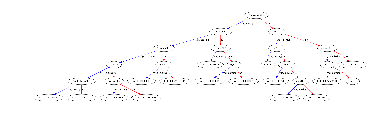

In [87]:
#ploting the tree 
#Plotting out XGBoost Model: 
import matplotlib.pyplot as plt

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/graphviz-2.38/release/bin/'
import graphviz

xgb.plot_tree(model2,num_trees=0)
plt.rcParams['figure.figsize'] = [600, 200]
plt.savefig('model2.png')



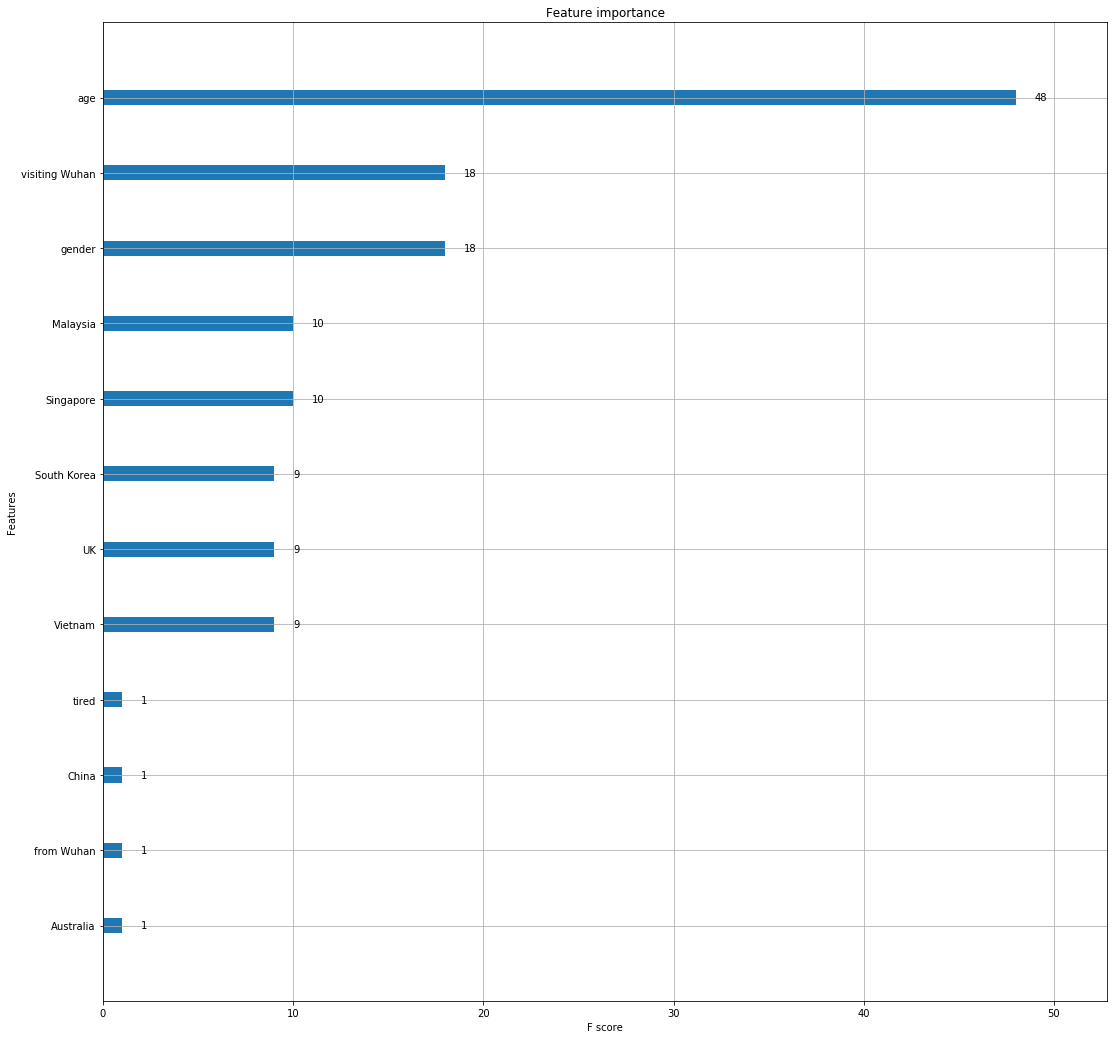

In [89]:
#plotting the variable importance

xgb.plot_importance(model2)
plt.rcParams['figure.figsize'] = [16, 16]
plt.show()

Saving our models to export them as pickle 

In [53]:
pickle.dump(model, open("pima.pickle.dat", "wb"))
pickle.dump(model1, open("pima1.pickle.dat", "wb"))
pickle.dump(model2, open("pima2.pickle.dat", "wb"))
pickle.dump(model21, open("pima21.pickle.dat", "wb"))

In [65]:
X.columns

Index(['gender', 'age', 'visiting Wuhan', 'from Wuhan', ' abdominal pain',
       ' chest pain', ' chill', ' cough', ' diarrhea',
       ' difficult in breathing', ' dyspnea', ' joint pain',
       ' loss of appetite', ' muscle pain', ' pneumonia', ' sputum', ' thirst',
       'fever', 'flu symptoms', 'headache', 'joint pain', 'malaise', 'nausea',
       'physical discomfort', 'runny nose', 'sore body', 'throat pain',
       'tired', 'vomiting', 'Afghanistan', 'Algeria', 'Australia', 'Austria',
       'Bahrain', 'Belgium', 'Cambodia', 'Canada', 'China', 'Croatia', 'Egypt',
       'Finland', 'France', 'Germany', 'Hong Kong', 'India', 'Iran', 'Israel',
       'Italy', 'Japan', 'Kuwait', 'Lebanon', 'Malaysia', 'Nepal',
       'Phillipines', 'Russia', 'Singapore', 'South Korea', 'Spain',
       'Sri Lanka', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'UAE', 'UK',
       'USA', 'Vietnam'],
      dtype='object')

In [52]:
joblib.dump(model, 'classifier.joblib')
joblib.dump(model1, 'classifier1.joblib')
joblib.dump(model2, 'classifier2.joblib')
joblib.dump(model21, 'classifier21.joblib')

['classifier21.joblib']